# Bloco 1: Importação das bibliotecas

In [25]:
!pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
    ConfusionMatrixDisplay
)

# Bloco 2: Carregar o dataset

In [3]:
df_titanic = sns.load_dataset("titanic")
df_titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


# Bloco 3: Tratamento de dados

## Verificação de dados faltantes

In [4]:
print(df_titanic.isnull().sum())

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64


- Como há muitos dados faltantes em "deck", será removida a coluna.

- Em "age" será aplicada a mediana, já que temos uma ampla variação de idades, com idades muito baixas e muito altas.

- E em "embarked" será aplicada a moda.

## Definição de colunas que serão utilizadas

Serão descartadas as colunas que possuem informação em duplicidade e que possuem uma grande quantidade de dados faltantes.

In [5]:
RANDOM_STATE = 42

X = df_titanic.drop(['survived', 'deck', 'alive', 'class', 'who', 'adult_male', 'embark_town'], axis=1)
y = df_titanic['survived']

## Separação em teste e treino

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
print(f"\nDados divididos em {len(X_train)} amostras de treino e {len(X_test)} de teste.")


Dados divididos em 712 amostras de treino e 179 de teste.


## Tratamento de dados faltantes e dados categóricos

In [7]:
features_categoricas = ['sex', 'embarked', 'pclass']
features_numericas = ['age', 'fare', 'sibsp', 'parch']

### Criação de pipelines

In [8]:
categoricos_transformados = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numericos_transformados = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessamento = ColumnTransformer(
    transformers = [
        ('cat', categoricos_transformados, features_categoricas),
        ('num', numericos_transformados, features_numericas)
    ],
    remainder='passthrough'
)

### Aplicação do pré-processamento

In [9]:
preprocessamento.fit(X_train)

X_train_processado = preprocessamento.transform(X_train)
X_test_processado = preprocessamento.transform(X_test)

# Bloco 4: Definição do modelo

In [10]:
kfold_estratificado = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

n_iter_search = 50

## **SVM**

In [11]:
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessamento),
    ('classifier', SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE))
])


params_svm = {
    'classifier__C': uniform(0.1, 100),
    'classifier__gamma': ['scale', 'auto'] + list(np.logspace(-3, 2, 8))
}

## **Random Forest**

In [12]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessamento),
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))
])

params_rf = {
    'classifier__n_estimators': randint(100, 500),
    'classifier__max_depth': [5, 10, 20, None],
    'classifier__min_samples_leaf': randint(1, 5),
    'classifier__max_features': ['sqrt', 'log2', None]
}

## **XGBoost**

In [13]:
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessamento),
    ('classifier', XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss'))
])

params_xgb = {
    'classifier__n_estimators': randint(100, 1000),
    'classifier__learning_rate': uniform(0.01, 0.3),
    'classifier__max_depth': randint(3, 10),
    'classifier__subsample': uniform(0.7, 0.3),
    'classifier__colsample_bytree': uniform(0.7, 0.3)
}

# Bloco 5: Treinar modelo

## **SVM (RBF)**

In [14]:
search_svm = RandomizedSearchCV(
    svm_pipeline,
    param_distributions=params_svm,
    n_iter=n_iter_search,
    cv=kfold_estratificado,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE
)
search_svm.fit(X_train, y_train)
print(f"Melhor ROC-AUC (CV): {search_svm.best_score_:.4f}")
print(f"Melhores parâmetros: {search_svm.best_params_}\n")

Melhor ROC-AUC (CV): 0.8476
Melhores parâmetros: {'classifier__C': np.float64(0.17787658410143284), 'classifier__gamma': np.float64(0.02682695795279726)}



## **Random Forest**

In [15]:
search_rf = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=params_rf,
    n_iter=n_iter_search,
    cv=kfold_estratificado,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE
)
search_rf.fit(X_train, y_train)
print(f"Melhor ROC-AUC (CV): {search_rf.best_score_:.4f}")
print(f"Melhores parâmetros: {search_rf.best_params_}\n")

Melhor ROC-AUC (CV): 0.8576
Melhores parâmetros: {'classifier__max_depth': 5, 'classifier__max_features': None, 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 230}



## **XGBoost**

In [16]:
search_xgb = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=params_xgb,
    n_iter=n_iter_search,
    cv=kfold_estratificado,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE
)
search_xgb.fit(X_train, y_train)
print(f"Melhor ROC-AUC (CV): {search_xgb.best_score_:.4f}")
print(f"Melhores parâmetros: {search_xgb.best_params_}\n")

Melhor ROC-AUC (CV): 0.8588
Melhores parâmetros: {'classifier__colsample_bytree': np.float64(0.8834959481464842), 'classifier__learning_rate': np.float64(0.012119891565915222), 'classifier__max_depth': 3, 'classifier__n_estimators': 660, 'classifier__subsample': np.float64(0.8574323980775167)}



# Bloco 6: Avaliação do modelo

## Cálculo das métricas finais no conjunto de testes

In [34]:
best_models = {
    "SVM": search_svm.best_estimator_,
    "Random Forest": search_rf.best_estimator_,
    "XGBoost": search_xgb.best_estimator_
}

# Lista para guardar os resultados da tabela
metric_results = []
# Dicionário para guardar os dados dos plots
plot_data = {}
# Dicionário para guardar as Matrizes de Confusão
confusion_matrices = {}

for name, model in best_models.items():
    # Previsões de classe (0 ou 1)
    y_pred = model.predict(X_test)

    # Previsões de probabilidade (para ROC-AUC)
    y_probs = model.predict_proba(X_test)[:, 1]

    # Calcular métricas
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_probs)

    # Cálculo e extração dos valores da matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    vn, fp, fn, vp = cm.ravel()

    confusion_matrices[name] = cm

    # Adicionar resultados à lista
    metric_results.append({
        "Modelo": name,
        "ROC-AUC": roc_auc,
        "Acurácia": acc,
        "F1-Score": f1,
        "Verdadeiros-Positivos": vp,
        "Falsos-Negativos": fn,
        "Falsos-Positivos": fp,
        "Verdadeiros-Negativos": vn
    })

    # Guardar dados para os plots
    plot_data[name] = {
        'probs': y_probs,
        'roc_auc': roc_auc
    }

## **Plots comparativos**

### **Curva ROC**

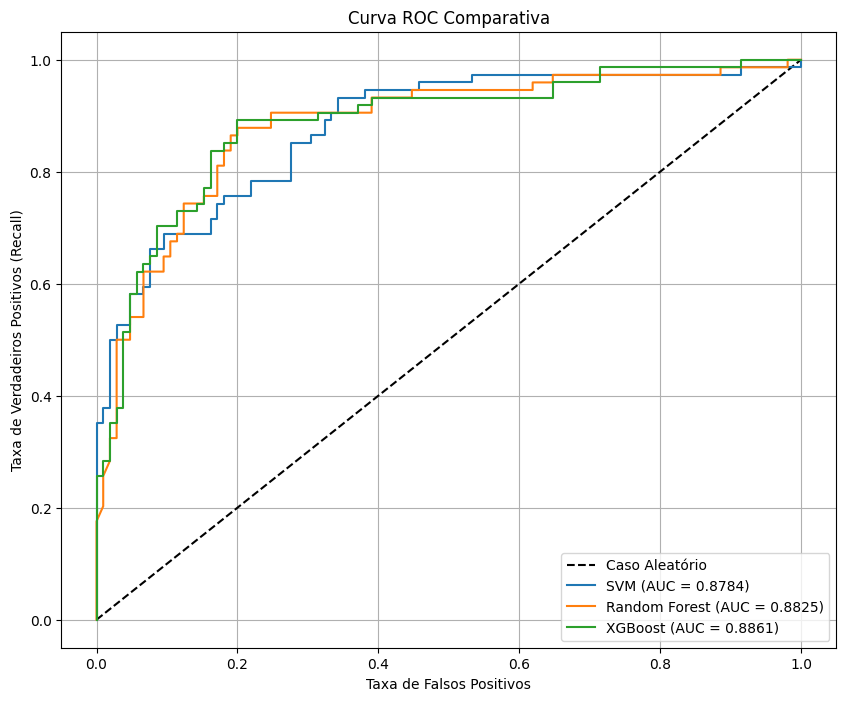

In [35]:
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Caso Aleatório')
for name, data in plot_data.items():
    fpr, tpr, _ = roc_curve(y_test, data['probs'])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {data['roc_auc']:.4f})")
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos (Recall)')
plt.title('Curva ROC Comparativa')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### **Curva Precision-Recall**

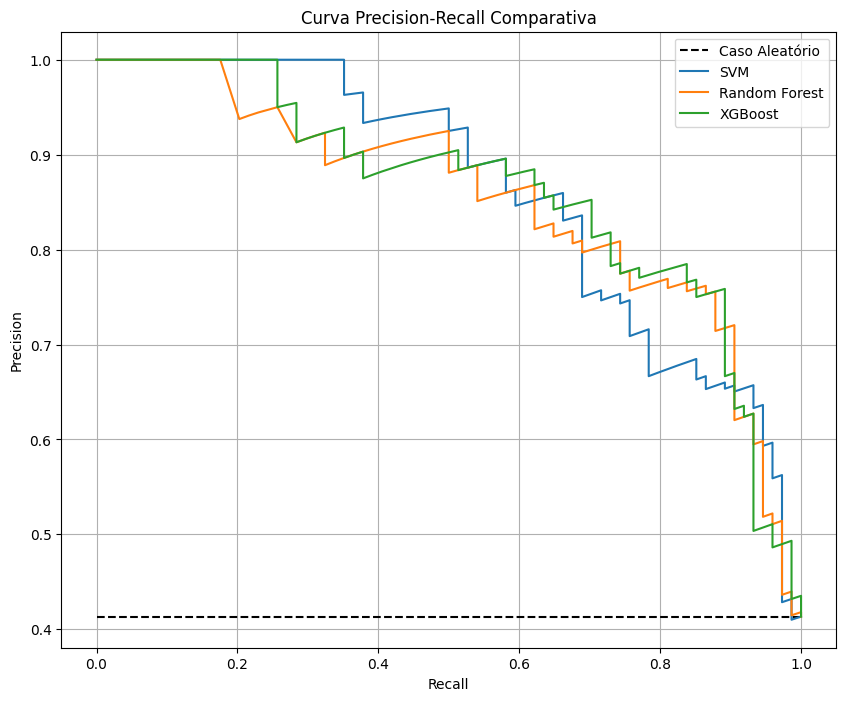

In [36]:
plt.figure(figsize=(10, 8))
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], 'k--', label='Caso Aleatório')
for name, data in plot_data.items():
    precision, recall, _ = precision_recall_curve(y_test, data['probs'])
    plt.plot(recall, precision, label=name)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall Comparativa')
plt.legend(loc='upper right')
plt.grid()
plt.show()

## **Matrizes de confusão**

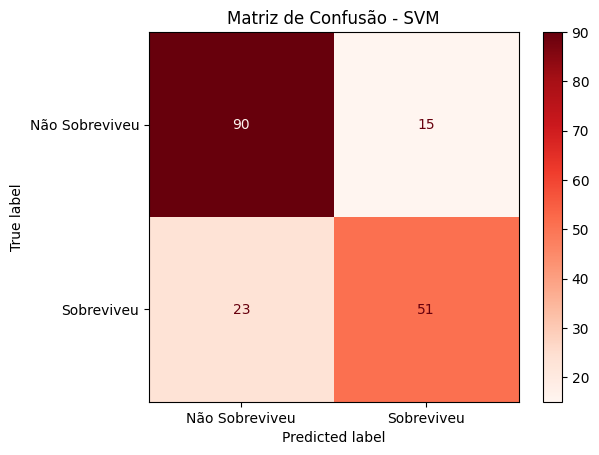

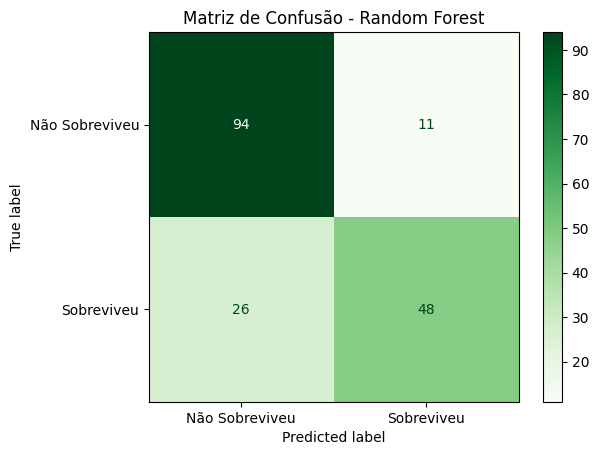

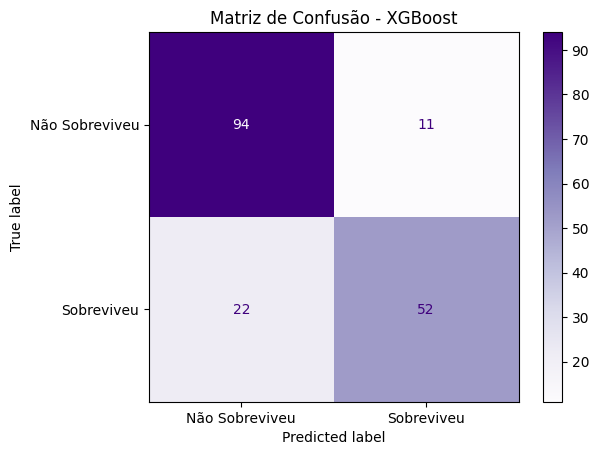

In [38]:
model_colors = {
    "SVM": "Reds",
    "Random Forest": "Greens",
    "XGBoost": "Purples"
}

for name, cm in confusion_matrices.items():

    color_map = model_colors.get(name, 'Reds')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Não Sobreviveu', 'Sobreviveu'])
    disp.plot(cmap=color_map, xticks_rotation='horizontal')

    plt.title(f'Matriz de Confusão - {name}')
    plt.show()

## **Tabela comparativa de métricas entre modelos**

In [41]:
df_metrics = pd.DataFrame(metric_results)
df_metrics.set_index("Modelo", inplace=True)

colunas_ordenadas = ['ROC-AUC', 'Acurácia', 'F1-Score', 'Verdadeiros-Positivos', 'Falsos-Negativos', 'Falsos-Positivos', 'Verdadeiros-Negativos']
df_metrics = df_metrics[colunas_ordenadas]
df_metrics.sort_values(by="ROC-AUC", ascending=False, inplace=True)

# 1. Definir o formato das colunas de (float) para 4 casas decimais
df_styled = df_metrics.style.format({
    "ROC-AUC": "{:.4f}",
    "Acurácia": "{:.4f}",
    "F1-Score": "{:.4f}"
})

# 2. Destacar os maiores valores (melhores) em verde
df_styled = df_styled.highlight_max(color='#B5E5A6', subset=['ROC-AUC', 'Acurácia', 'F1-Score', 'Verdadeiros-Positivos', 'Verdadeiros-Negativos'])

# 3. Destacar os menores valores para os erros em laranja
df_styled = df_styled.highlight_min(color='#FFCC99', subset=['Falsos-Negativos', 'Falsos-Positivos'])

df_styled

,ROC-AUC,Acurácia,F1-Score,Verdadeiros-Positivos,Falsos-Negativos,Falsos-Positivos,Verdadeiros-Negativos
Modelo,,,,,,,
XGBoost,0.8861,0.8156,0.7591,52,22,11,94
Random Forest,0.8825,0.7933,0.7218,48,26,11,94
SVM,0.8784,0.7877,0.7286,51,23,15,90


## **Análise comparativa entre o ROC-AUC de teste e treino para verificar overfitting**

In [47]:
# 1. Dicionário com os dados
overfit_data = {
    'Score Treino': [
        search_xgb.best_score_,
        search_rf.best_score_,
        search_svm.best_score_
    ],
    'Score Teste': [
        df_metrics.loc['SVM', 'ROC-AUC'],
        df_metrics.loc['Random Forest', 'ROC-AUC'],
        df_metrics.loc['XGBoost', 'ROC-AUC']
    ]
}

# 2. Criar o DataFrame
df_overfit = pd.DataFrame(overfit_data, index=['SVM', 'Random Forest', 'XGBoost'])

# 3. Calcular a diferença (Delta)
df_overfit['Diferença (Teste - Treino)'] = df_overfit['Score Teste'] - df_overfit['Score Treino']

df_overfit_styled = df_overfit.style.format({
    'Score Treino': '{:.4f}',
    'Score Teste': '{:.4f}',
    'Diferença (Teste - Treino)': '{:+.4f}'
}).background_gradient(
    cmap='RdYlGn',
    subset=['Diferença (Teste - Treino)'],
    vmin=-0.05,
    vmax=0.05
)

df_overfit_styled

,Score Treino,Score Teste,Diferença (Teste - Treino)
SVM,0.8588,0.8784,+0.0196
Random Forest,0.8576,0.8825,+0.0249
XGBoost,0.8476,0.8861,+0.0385


# Bloco 7: Conclusões

## 1. Qual modelo apresentou melhor desempenho?
O modelo com maior desempenho foi o **XGBoost**, apresentando maior acurácia (81,56%), maior capacidade em separar as classes, ou seja maior ROC-AUC (0.8861) e maior F1 Score (menor quantidade de falsos positivos e falsos negativos, sendo 0.7591).

---

## 2. Algum modelo mostrou sinais de overfitting?

Todos os modelos obtiveram um desempenho superior no teste em relação ao treino, indicando que os modelos generalizaram muito bem para os dados novos.

---

## 3. Quais foram as dificuldades no pré-processamento?
As principais dificuldades no pré-processamento foram:
- **O tratamento de dados faltantes:** Houveram três colunas diferentes que estavam com dados ausentes e para cada uma delas foi adotada uma forma diferente de tratamento, sendo elas:
  - **deck**: cerca de 78% dos dados estavam ausentes, portanto optou-se por remover a coluna.
  - **age**: como as idades eram muito variadas (desde bebês até idosos), optou-se por preencher os valores faltantes com a mediana.
  - **embarked**: é uma coluna categórica e foi utilizada a moda para preencher os valores.

- **Dados categóricos:** Haviam colunas com dados textuais e, para garantir que todos os modelos conseguissem interpretar os valores, foi necessário utilizar o OneHotEnconder para transformá-los em dados numéricos.

- **Dados numéricos:** Para garantir que todos os dados fossem interpretados com a mesma escala foi utilizado o StadartScaler.

